In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/SilverBlaze075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-01 10:38:42 - INFO - 947346029.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/SilverBlaze075/03/log.log', param_file='saved_models/kgc/SilverBlaze075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/SilverBlaze075/03/checkpoint/', model_path='saved_models/kgc/SilverBlaze075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='SilverBlaze', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_to

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2023-01-01 10:38:42 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2023-01-01 10:38:42 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:38:42 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:38:42 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:38:42 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:38:42 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2023-01-01 10:38:42 - INFO - data_helper.py - 441 - ==========
2023-01-01 10:38:42 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:38:42 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:38:42 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:38:42 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:38:42 - INFO - data_helper.py - 443 - ==========
2023-01-01 10:38:42 - INFO - data_helper.py - 445 - entity_spec

13725 16842


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

In [14]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### 白銀
Who took out the White Silver Blaze? (criminal & explanation) 
被害者: Silver_Blaze
犯人: 
犯行動機: 

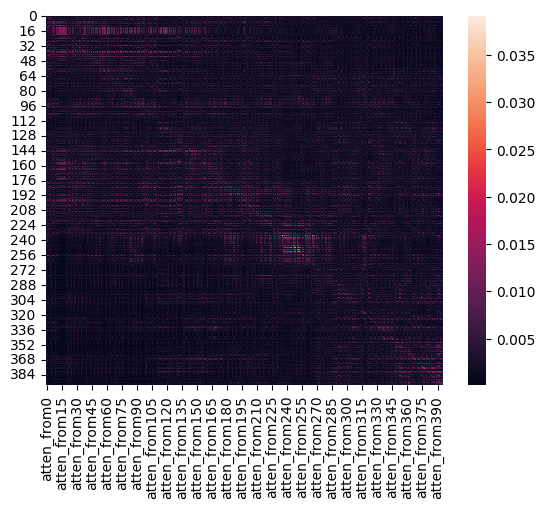

,predicate,whom,subject,why,what,where
0,word.predicate:have,SilverBlaze:Fitzroy_Simpson,SilverBlaze:Fitzroy_Simpson,SilverBlaze:two_young_men,SilverBlaze:Fitzroy_Simpson,SilverBlaze:John_Straker
1,word.predicate:find,AllTitle:Holmes,AllTitle:Holmes,SpeckledBand:Julia_s_bedroom,AllTitle:Watson,SilverBlaze:Fitzroy_Simpson
2,word.predicate:say,SilverBlaze:Ned_Hunter,SpeckledBand:Roylott,SilverBlaze:John_Straker,SilverBlaze:John_Straker,SpeckledBand:Julia_s_bedroom
3,word.predicate:enter,SilverBlaze:Silver_Blaze,SilverBlaze:Ned_Hunter,DateTime:1883-04-01T15:00:00,AllTitle:Holmes,SilverBlaze:stable
4,word.predicate:exist,SpeckledBand:Roylott,AllTitle:Watson,SilverBlaze:042,SpeckledBand:Julia_s_bedroom,SilverBlaze:Edith_Baxter
5,word.predicate:marry,AbbeyGrange:Criminal,SpeckledBand:Helen,word.predicate:get,SpeckledBand:Roylott,AllTitle:Holmes
6,word.predicate:see,AllTitle:Watson,SilverBlaze:John_Straker,SpeckledBand:VentilationHole,SilverBlaze:Ned_Hunter,SpeckledBand:Roylott
7,word.predicate:open,SilverBlaze:John_Straker,SilverBlaze:police,SilverBlaze:Mantle_of_John_Straker,SilverBlaze:Silver_Blaze,SilverBlaze:Ned_Hunter
8,AllTitle:Holmes,SpeckledBand:Helen,SilverBlaze:Edith_Baxter,ACaseOfIdentity:Hosmer,SilverBlaze:Edith_Baxter,ACaseOfIdentity:Woman
9,word.predicate:sit,SilverBlaze:Inspector_Gregory,SilverBlaze:Silver_Blaze,SpeckledBand:1883-04-01T15,ACaseOfIdentity:Hosmer,SpeckledBand:1883-04-01T15


376

['SilverBlaze:295a', 'kgc:to', 'SilverBlaze:Silas_Brown']

,head,relation,tail,atten_from376
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.019939
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.011536
209,SilverBlaze:263,kgc:subject,SilverBlaze:Colonel_Ross,0.011434
190,SilverBlaze:259,kgc:subject,SilverBlaze:Inspector_Gregory,0.010919
192,SilverBlaze:259,kgc:what,SilverBlaze:Murder_scene,0.010201
368,SilverBlaze:294,kgc:to,SilverBlaze:Stableman,0.008964
379,SilverBlaze:296,kgc:subject,SilverBlaze:Stableman,0.008871
174,SilverBlaze:255,kgc:what,SilverBlaze:256,0.007316
211,SilverBlaze:263,kgc:what,SilverBlaze:264,0.007229
194,SilverBlaze:260,kgc:subject,SilverBlaze:Inspector_Gregory,0.007080


----------


377

['SilverBlaze:295a', 'kgc:when', 'SilverBlaze:5_00_tomorrow_morning']

,head,relation,tail,atten_from377
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.024062
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.021351
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.015019
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.014962
392,mask_e,kgc:subject,mask_e,0.011675
368,SilverBlaze:294,kgc:to,SilverBlaze:Stableman,0.010285
144,SilverBlaze:249,kgc:what,SilverBlaze:250,0.009554
391,mask_e,kgc:whom,mask_e,0.009339
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.008946
302,SilverBlaze:281,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.008834


----------


378

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from378
284,SilverBlaze:277,kgc:why,SilverBlaze:278,0.005826
288,SilverBlaze:278,kgc:what,SilverBlaze:rain,0.005614
40,bos_e,bos_r,bos_e,0.005570
44,bos_e,bos_r,bos_e,0.005134
21,bos_e,bos_r,bos_e,0.005084
200,bos_e,bos_r,bos_e,0.005011
146,bos_e,bos_r,bos_e,0.004887
35,bos_e,bos_r,bos_e,0.004862
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.004860
32,bos_e,bos_r,bos_e,0.004839


----------


379

['SilverBlaze:296', 'kgc:subject', 'SilverBlaze:Stableman']

,head,relation,tail,atten_from379
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.013074
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.011832
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.011154
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.010945
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.010056
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.009780
379,SilverBlaze:296,kgc:subject,SilverBlaze:Stableman,0.009671
368,SilverBlaze:294,kgc:to,SilverBlaze:Stableman,0.009244
298,SilverBlaze:280,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.008821
302,SilverBlaze:281,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.008478


----------


380

['SilverBlaze:296', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from380
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.011180
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.010170
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.009223
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.008531
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.008255
333,SilverBlaze:286,kgc:what,SilverBlaze:Traces_of_man_s_shoes,0.007839
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.007683
302,SilverBlaze:281,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.007340
306,SilverBlaze:282,kgc:what,SilverBlaze:Horseshoe_marks,0.007332
265,SilverBlaze:274,kgc:subject,SilverBlaze:Gypsy,0.007121


----------


381

['SilverBlaze:296', 'kgc:what', 'SilverBlaze:297']

,head,relation,tail,atten_from381
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.015782
298,SilverBlaze:280,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.013522
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.013336
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.012717
302,SilverBlaze:281,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.011361
333,SilverBlaze:286,kgc:what,SilverBlaze:Traces_of_man_s_shoes,0.010105
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.009692
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.009076
192,SilverBlaze:259,kgc:what,SilverBlaze:Murder_scene,0.008884
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.008215


----------


382

['SilverBlaze:296', 'kgc:what', 'SilverBlaze:298']

,head,relation,tail,atten_from382
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.016896
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.015463
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.012588
298,SilverBlaze:280,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.011512
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.010515
302,SilverBlaze:281,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.010090
374,SilverBlaze:295a,kgc:subject,AllTitle:Holmes,0.009817
192,SilverBlaze:259,kgc:what,SilverBlaze:Murder_scene,0.009467
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.009249
333,SilverBlaze:286,kgc:what,SilverBlaze:Traces_of_man_s_shoes,0.009081


----------


383

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from383
284,SilverBlaze:277,kgc:why,SilverBlaze:278,0.005820
40,bos_e,bos_r,bos_e,0.005685
288,SilverBlaze:278,kgc:what,SilverBlaze:rain,0.005631
44,bos_e,bos_r,bos_e,0.005266
21,bos_e,bos_r,bos_e,0.005202
200,bos_e,bos_r,bos_e,0.005052
146,bos_e,bos_r,bos_e,0.004993
35,bos_e,bos_r,bos_e,0.004971
32,bos_e,bos_r,bos_e,0.004951
9,bos_e,bos_r,bos_e,0.004886


----------


384

['SilverBlaze:297', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from384
301,SilverBlaze:281,kgc:hasPredicate,word.predicate:search,0.013887
385,SilverBlaze:297,kgc:hasPredicate,word.predicate:canMeet,0.010971
375,SilverBlaze:295a,kgc:hasPredicate,word.predicate:meet,0.010629
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.010378
156,SilverBlaze:252,kgc:hasPredicate,word.predicate:ask,0.009419
354,SilverBlaze:291,kgc:hasPredicate,word.predicate:trace,0.008795
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.008587
366,SilverBlaze:294,kgc:hasPredicate,word.predicate:say,0.008098
182,SilverBlaze:257,kgc:hasPredicate,word.predicate:ask,0.007818
362,SilverBlaze:293,kgc:hasPredicate,word.predicate:comeOut,0.007291


----------


385

['SilverBlaze:297', 'kgc:hasPredicate', 'word.predicate:canMeet']

,head,relation,tail,atten_from385
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.017469
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.015164
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.013778
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.013765
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.012932
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.012522
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.010138
324,SilverBlaze:285,kgc:what,SilverBlaze:Horseshoe_marks,0.010089
114,SilverBlaze:243,kgc:what,SilverBlaze:244,0.009903
288,SilverBlaze:278,kgc:what,SilverBlaze:rain,0.009508


----------


386

['SilverBlaze:297', 'kgc:to', 'SilverBlaze:Silas_Brown']

,head,relation,tail,atten_from386
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.013359
209,SilverBlaze:263,kgc:subject,SilverBlaze:Colonel_Ross,0.010053
192,SilverBlaze:259,kgc:what,SilverBlaze:Murder_scene,0.009803
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.009694
190,SilverBlaze:259,kgc:subject,SilverBlaze:Inspector_Gregory,0.009293
59,SilverBlaze:230,kgc:what,SilverBlaze:232,0.009037
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.008792
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.008686
232,SilverBlaze:268,kgc:what,SilverBlaze:269,0.007999
387,SilverBlaze:297,kgc:when,SilverBlaze:early_morning,0.007871


----------


387

['SilverBlaze:297', 'kgc:when', 'SilverBlaze:early_morning']

,head,relation,tail,atten_from387
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.018699
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.017854
377,SilverBlaze:295a,kgc:when,SilverBlaze:5_00_tomorrow_morning,0.017061
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.015152
392,mask_e,kgc:subject,mask_e,0.014588
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.014209
325,SilverBlaze:285,kgc:where,SilverBlaze:Where_is_the_slope_of_the_land,0.012576
391,mask_e,kgc:whom,mask_e,0.012247
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.011274
324,SilverBlaze:285,kgc:what,SilverBlaze:Horseshoe_marks,0.010176


----------


388

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from388
284,SilverBlaze:277,kgc:why,SilverBlaze:278,0.006134
288,SilverBlaze:278,kgc:what,SilverBlaze:rain,0.005639
40,bos_e,bos_r,bos_e,0.005524
44,bos_e,bos_r,bos_e,0.005155
21,bos_e,bos_r,bos_e,0.005046
200,bos_e,bos_r,bos_e,0.004886
146,bos_e,bos_r,bos_e,0.004823
35,bos_e,bos_r,bos_e,0.004817
32,bos_e,bos_r,bos_e,0.004817
9,bos_e,bos_r,bos_e,0.004773


----------


389

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from389
190,SilverBlaze:259,kgc:subject,SilverBlaze:Inspector_Gregory,0.012250
354,SilverBlaze:291,kgc:hasPredicate,word.predicate:trace,0.011120
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.011111
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.010786
385,SilverBlaze:297,kgc:hasPredicate,word.predicate:canMeet,0.010401
392,mask_e,kgc:subject,mask_e,0.010384
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.009606
235,SilverBlaze:269,kgc:subject,SilverBlaze:Silver_Blaze,0.009536
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.009503
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.009463


----------


390

['mask_e', 'kgc:hasPredicate', 'word.predicate:bring']

,head,relation,tail,atten_from390
324,SilverBlaze:285,kgc:what,SilverBlaze:Horseshoe_marks,0.014816
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.013171
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.013109
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.012997
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.012571
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.011988
376,SilverBlaze:295a,kgc:to,SilverBlaze:Silas_Brown,0.010398
394,mask_e,kgc:what,SilverBlaze:Silver_Blaze,0.010026
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.009878
392,mask_e,kgc:subject,mask_e,0.009549


----------


391

['mask_e', 'kgc:whom', 'mask_e']

,head,relation,tail,atten_from391
190,SilverBlaze:259,kgc:subject,SilverBlaze:Inspector_Gregory,0.014232
385,SilverBlaze:297,kgc:hasPredicate,word.predicate:canMeet,0.013545
354,SilverBlaze:291,kgc:hasPredicate,word.predicate:trace,0.013523
375,SilverBlaze:295a,kgc:hasPredicate,word.predicate:meet,0.011913
209,SilverBlaze:263,kgc:subject,SilverBlaze:Colonel_Ross,0.011816
235,SilverBlaze:269,kgc:subject,SilverBlaze:Silver_Blaze,0.011688
297,SilverBlaze:280,kgc:hasPredicate,word.predicate:search,0.011669
278,SilverBlaze:276,kgc:subject,SilverBlaze:Silver_Blaze,0.009359
213,SilverBlaze:264,kgc:subject,SilverBlaze:Silver_Blaze,0.009230
293,SilverBlaze:279,kgc:hasPredicate,word.predicate:go,0.009127


----------


392

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from392
392,mask_e,kgc:subject,mask_e,0.012903
190,SilverBlaze:259,kgc:subject,SilverBlaze:Inspector_Gregory,0.012633
361,SilverBlaze:293,kgc:subject,SilverBlaze:Stableman,0.012284
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.010961
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.010552
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.010525
235,SilverBlaze:269,kgc:subject,SilverBlaze:Silver_Blaze,0.010518
222,SilverBlaze:266,kgc:subject,SilverBlaze:Silver_Blaze,0.010473
213,SilverBlaze:264,kgc:subject,SilverBlaze:Silver_Blaze,0.010268
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.010206


----------


393

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from393
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.016455
325,SilverBlaze:285,kgc:where,SilverBlaze:Where_is_the_slope_of_the_land,0.014699
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.014186
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.014006
359,SilverBlaze:292,kgc:where,SilverBlaze:The_entrance_of_the_stables_of_Map...,0.013989
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.013597
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.012364
324,SilverBlaze:285,kgc:what,SilverBlaze:Horseshoe_marks,0.011885
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.011798
379,SilverBlaze:296,kgc:subject,SilverBlaze:Stableman,0.010744


----------


394

['mask_e', 'kgc:what', 'SilverBlaze:Silver_Blaze']

,head,relation,tail,atten_from394
394,mask_e,kgc:what,SilverBlaze:Silver_Blaze,0.011244
361,SilverBlaze:293,kgc:subject,SilverBlaze:Stableman,0.010062
392,mask_e,kgc:subject,mask_e,0.009368
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.009166
384,SilverBlaze:297,kgc:subject,AllTitle:Holmes,0.009071
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.008883
393,mask_e,kgc:why,mask_e,0.008787
374,SilverBlaze:295a,kgc:subject,AllTitle:Holmes,0.008582
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.008550
389,mask_e,kgc:infoSource,AllTitle:Holmes,0.008433


----------


395

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from395
350,SilverBlaze:290,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.012902
372,SilverBlaze:295,kgc:what,SilverBlaze:295a,0.011702
355,SilverBlaze:291,kgc:what,SilverBlaze:Footprint_that_is_oriented_towards...,0.011614
381,SilverBlaze:296,kgc:what,SilverBlaze:297,0.010985
367,SilverBlaze:294,kgc:what,SilverBlaze:295,0.010908
382,SilverBlaze:296,kgc:what,SilverBlaze:298,0.009593
298,SilverBlaze:280,kgc:what,SilverBlaze:Footprint_of_Silver_Blaze,0.009156
67,SilverBlaze:232,kgc:what,SilverBlaze:knife,0.008431
394,mask_e,kgc:what,SilverBlaze:Silver_Blaze,0.008387
359,SilverBlaze:292,kgc:where,SilverBlaze:The_entrance_of_the_stables_of_Map...,0.008285


----------


In [16]:
victim = 'SilverBlaze:Silver_Blaze'
df_ranking_SilverBlaze, df_attension_SilverBlaze = make_ranking(
    f'SilverBlaze:{297-80+1}', 'SilverBlaze:297', BRING, MASK_E, MASK_E, MASK_E, victim, MASK_E)

display(df_ranking_SilverBlaze.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SilverBlaze)
for i in range(len_-20, len_):
    display(i, df_attension_SilverBlaze.iloc[i,:3].tolist())
    display(df_attension_SilverBlaze.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")